In [87]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


# Set up


In [88]:
START = "2022-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " +(datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [118]:
data = yf.download(TICKER, start=START, end=END,multi_level_index=False)

data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


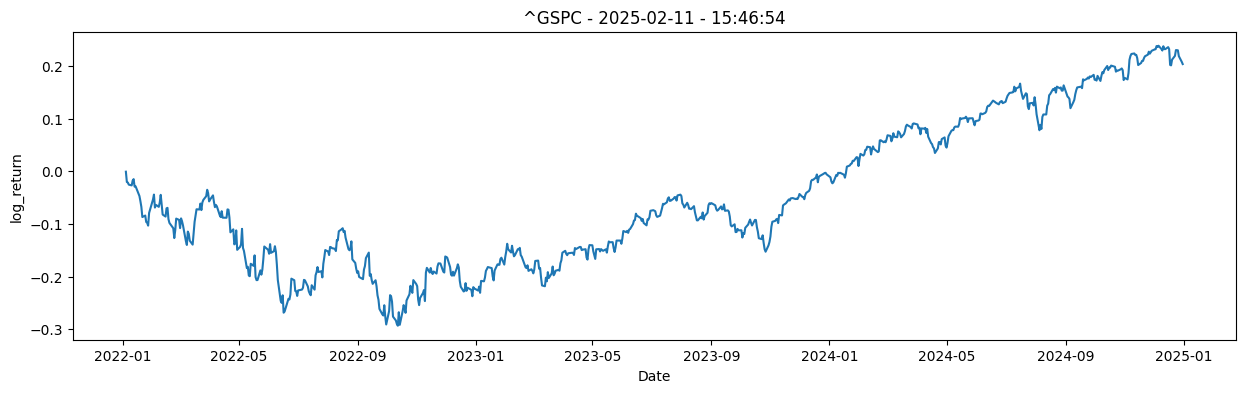

In [119]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(data["log_return"].cumsum()).set_title(TITLE)
plt.show()

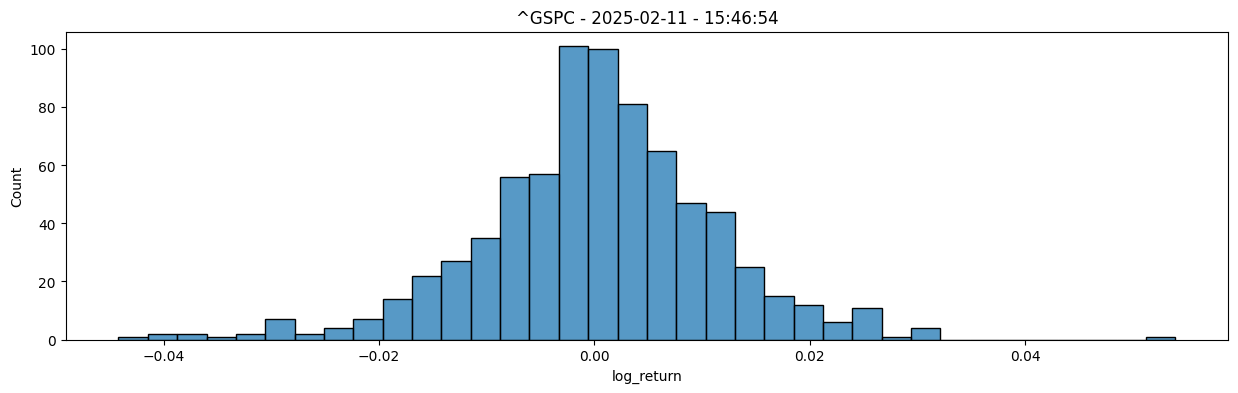

In [120]:
fig = plt.figure(figsize=(15,4))
sns.histplot(data["log_return"]).set_title(TITLE)
plt.show()

## SMA

In [121]:
def sma(data, t):
    return data.shift(1).rolling(t).mean()

In [122]:
Fast = 20
Slow = 50
Long = 200
data["SMA_fast"] = sma(data["Close"],Fast)
data["SMA_slow"] = sma(data["Close"],Slow)
data["SMA_long"] = sma(data["Close"],Long)

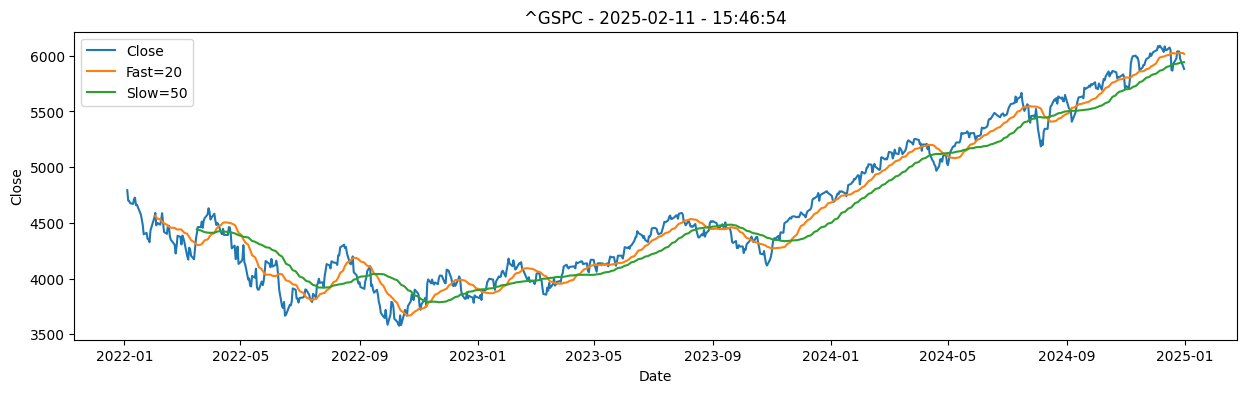

In [123]:
fig = plt.figure(figsize=(15,4))
ax1 = sns.lineplot(data["Close"],label="Close")
ax2 = sns.lineplot(data["SMA_fast"],label=f"{Fast=}")
ax3 = sns.lineplot(data["SMA_slow"],label=f"{Slow=}")
ax1.set_title(TITLE)
plt.legend()
plt.show()

In [124]:
data["bull"] = data["SMA_fast"] > data["SMA_slow"]
data.head(21)

,Open,High,Low,Close,Adj Close,Volume,log_return,SMA_fast,SMA_slow,SMA_long,bull
Date,,,,,,,,,,,
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,4793.540039,4683170000,-0.000630,NaN,NaN,NaN,False
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,4700.580078,4887960000,-0.019583,NaN,NaN,NaN,False
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,4696.049805,4295280000,-0.000964,NaN,NaN,NaN,False
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,4677.029785,4181510000,-0.004058,NaN,NaN,NaN,False
2022-01-10,4655.339844,4673.020020,4582.240234,4670.290039,4670.290039,4511810000,-0.001442,NaN,NaN,NaN,False
2022-01-11,4669.140137,4714.129883,4638.270020,4713.069824,4713.069824,4101590000,0.009118,NaN,NaN,NaN,False
2022-01-12,4728.589844,4748.830078,4706.709961,4726.350098,4726.350098,4048220000,0.002814,NaN,NaN,NaN,False
2022-01-13,4733.560059,4744.129883,4650.290039,4659.029785,4659.029785,4251730000,-0.014346,NaN,NaN,NaN,False
2022-01-14,4637.990234,4665.129883,4614.750000,4662.850098,4662.850098,4338490000,0.000820,NaN,NaN,NaN,False


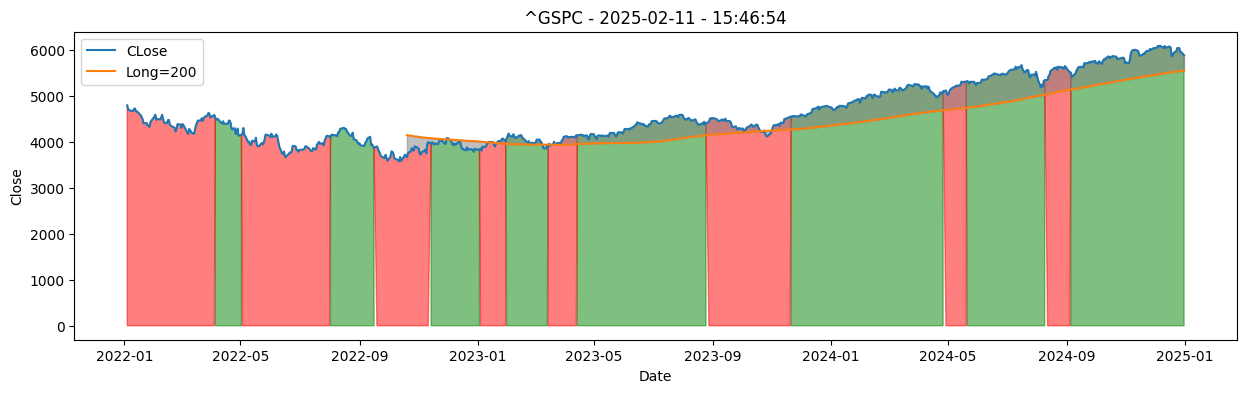

In [125]:
fig = plt.figure(figsize=(15,4))
plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)
ax1 = sns.lineplot(data["Close"], label="CLose")
ax1 = sns.lineplot(data["SMA_long"], label=f"{Long=}")
ax1.set_title(TITLE)
plt.show()

# Bull and bear markets

Text(0.5, 1.0, '^GSPC - 2025-02-11 - 15:46:54')

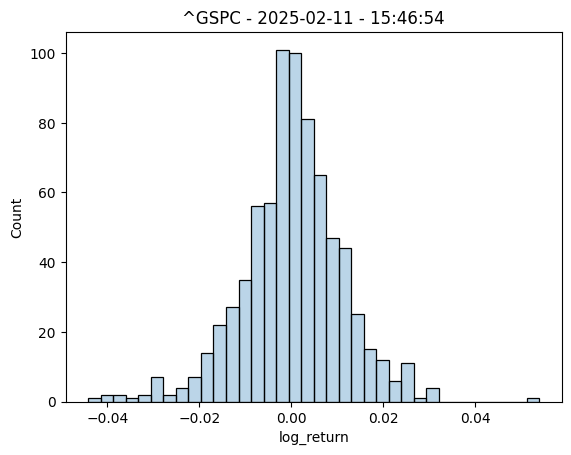

In [126]:
sns.histplot(data["log_return"],alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-11 - 15:46:54')

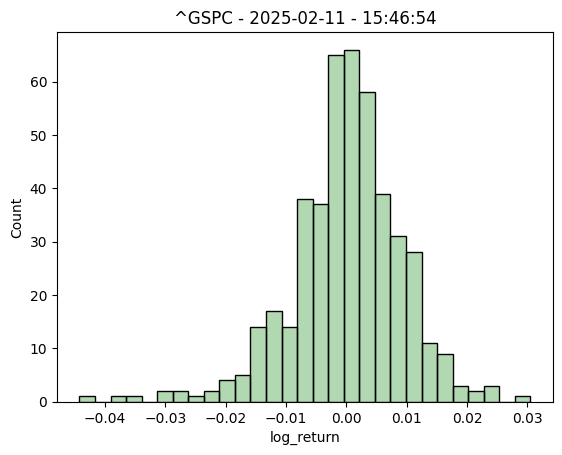

In [127]:
sns.histplot(data["log_return"].where(data["bull"]),color="green",alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-11 - 15:46:54')

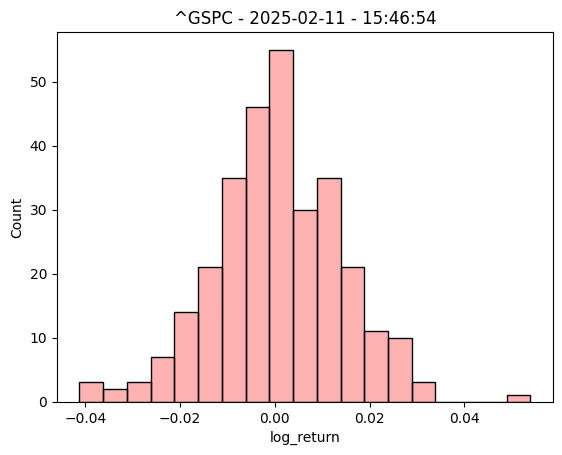

In [128]:
sns.histplot(data["log_return"].where(~data["bull"]),color="red",alpha=0.3).set_title(TITLE)

Text(0.5, 1.0, '^GSPC - 2025-02-11 - 15:46:54')

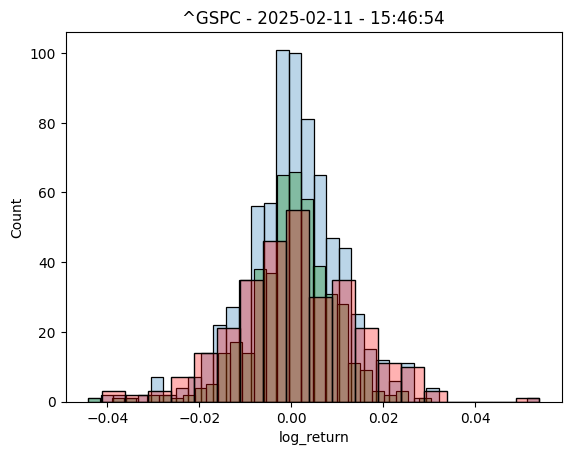

In [129]:
sns.histplot(data["log_return"],alpha=0.3).set_title(TITLE)
sns.histplot(data["log_return"].where(data["bull"]),color="green",alpha=0.3).set_title(TITLE)
sns.histplot(data["log_return"].where(~data["bull"]),color="red",alpha=0.3).set_title(TITLE)

# 1 - Statistical distributions

In [130]:
from scipy import stats

In [131]:
def jarque_bera(data):
    # Reject Null if 0.05>
    return stats.jarque_bera(data.dropna()).pvalue


def describe_returns(data):
    mean = data.mean()
    std = data.std()
    skew = data.skew()
    kurt = data.kurt()
    jarque = jarque_bera(data)

    return pd.DataFrame({"Mean %" : [mean], "Standard deviation %": [std], "Skew": [skew], "Kurtosis": [kurt], "Jarque-bera p value":[jarque]})

In [132]:
both = describe_returns(data['log_return'])
bull = describe_returns(data['log_return'].where(data['bull']))
bear = describe_returns(data['log_return'].where(~data['bull']))

In [133]:
combined = pd.concat([both,bull,bear])
combined.index = ["Both", "Bull", "Bear"]
combined["Mean %"] *= 100
combined["Standard deviation %"] *= 100

round(combined.T,4)

,Both,Bull,Bear
Mean %,0.0271,0.0040,0.0625
Standard deviation %,1.1032,0.9226,1.3343
Skew,-0.2219,-0.6350,-0.0386
Kurtosis,1.8105,2.3506,0.8378
Jarque-bera p value,0.0000,0.0000,0.0177


# Back testing

In [134]:
last = 0
# [Date, Buy, Balance, Position]
equity = [(data.index[0],0,10_000,0)]
for index, row in data.iterrows():

    buy = 0
    position = equity[-1][3]
    balance = equity[-1][2]
    if row["bull"] and not last: # Buy
        buy = 1
        position = balance // row["Open"]
        balance -= row["Open"] * position

    if not row["bull"] and last: # Sell
        buy = -1
        balance += row["Open"] * position
        position = 0

    equity.append((index, buy, balance, position))
    last = row["bull"]

equity = pd.DataFrame(equity,columns=["Date","buy","balance","position"])

equity = equity.set_index("Date")

data = data.join(equity)

data["value"] = (data["position"] * data["Close"]) + data["balance"]

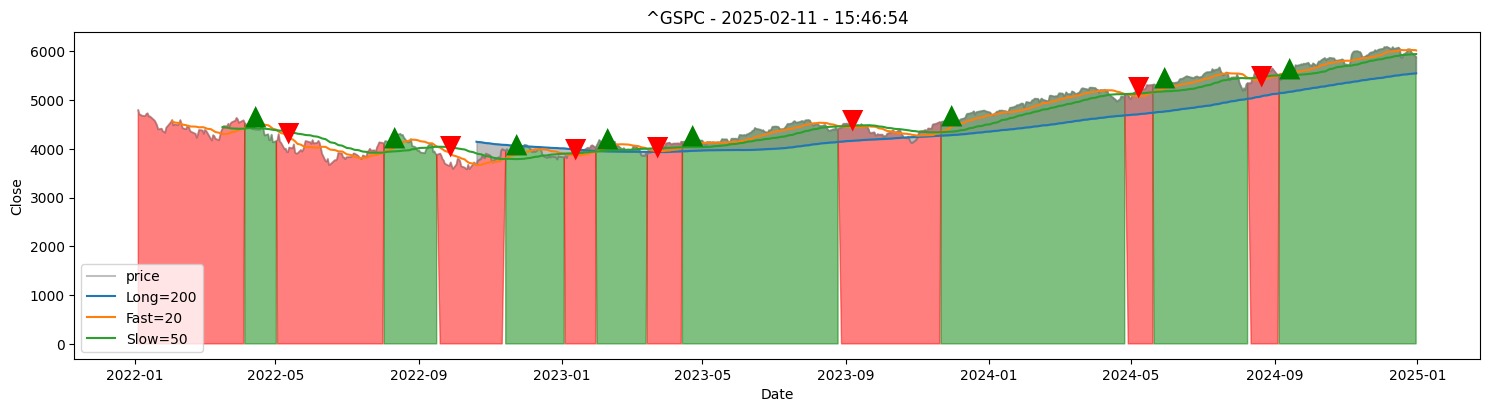

In [135]:
fig, ax1 = plt.subplots(figsize=(15,4))

plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)

ax1 = sns.lineplot(data["Close"],color="grey",alpha=0.5, label="price")
ax1 = sns.lineplot(data["SMA_long"],label=f"{Long=}")
ax1 = sns.lineplot(data["SMA_fast"], label=f"{Fast=}")
ax1 = sns.lineplot(data["SMA_slow"], label=f"{Slow=}")
# sns.lineplot(data["value"])

df_filt = data[data["buy"] != 0.0]

for index, value in df_filt.iterrows():
    if value["buy"] == -1.0:
        ax1.annotate("▼",(index,value["Close"]), color="red",fontsize=20)
    if value["buy"] == 1.0:
        ax1.annotate("▲",(index,value["Close"]), color="green",fontsize=20)

fig.tight_layout()
ax1.set_title(TITLE)
plt.show()

In [136]:
# data.to_excel("test.xlsx")

In [137]:
data["log_return"].sum()

0.20330508766787592

In [138]:
data["value_log_return"] = np.log((data["value"] / data["value"].shift(1)))

data["value_log_return"].sum()

-0.0641504714385959

<AxesSubplot: title={'center': '^GSPC - 2025-02-11 - 15:46:54'}, xlabel='Date', ylabel='value_log_return'>

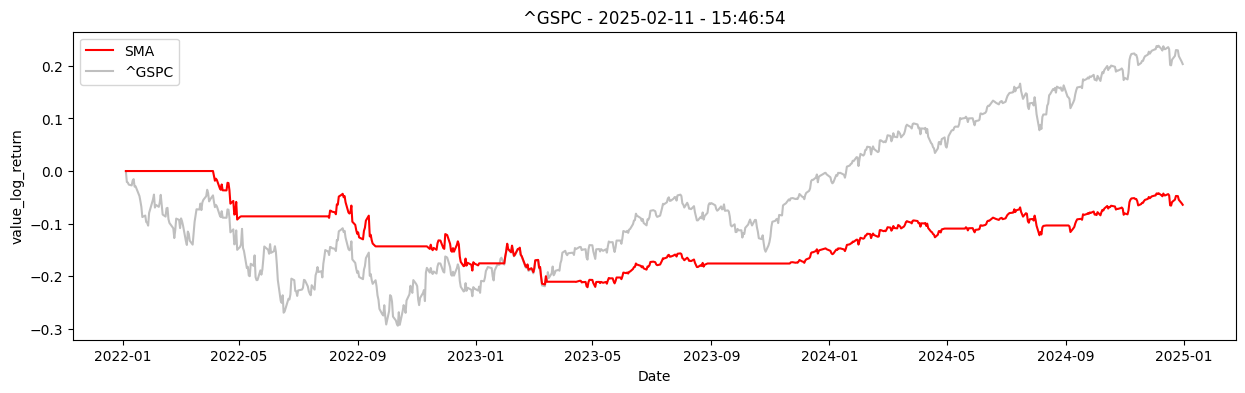

In [139]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.lineplot(data["value_log_return"].cumsum(),dashes=False,label="SMA",color="red").set_title(TITLE)
sns.lineplot(data["log_return"].cumsum(),dashes=False,label=TICKER,alpha=0.5,color="grey",zorder=0)


# Drawdown

<AxesSubplot: title={'center': '^GSPC - 2025-02-11 - 15:46:54'}, xlabel='Date', ylabel='value_log_return'>

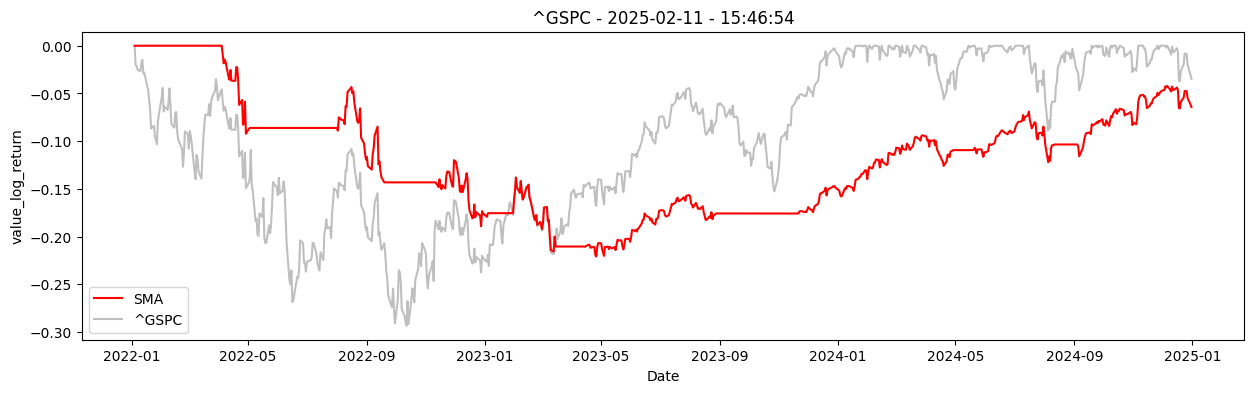

In [140]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.lineplot(data["value_log_return"].cumsum() - data["value_log_return"].cumsum().cummax(),dashes=False,label="SMA",color="red").set_title(TITLE)
sns.lineplot(data["log_return"].cumsum() - data["log_return"].cumsum().cummax(),dashes=False,label=TICKER, alpha=0.5,color="grey",zorder=0)

# Portfolio stats (annual)

In [141]:
data["log_return"].sum() / 5

0.040661017533575185

In [142]:
data["value_log_return"].sum() / 5

-0.012830094287719179

In [143]:
data["log_return"].std() * np.sqrt(252*5)

0.39134039601295306

In [144]:
data["value_log_return"].std() * np.sqrt(252*5)

0.19440734002069318

In [145]:
((data["log_return"].mean()) / (data["log_return"].std())) * np.sqrt(252)

0.38876229164052123

In [146]:
(data["value_log_return"].mean() / data["value_log_return"].std()) * np.sqrt(252)

-0.24726058739126255